### Load Data, drop empty Txt and Settings
----

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [2]:
## SETTINGS

# active models
SET_NN_active = False

SET_track_scores = False
SET_name_outputfile = "performance_260323.csv"

SET_datapath = "data_pp_sample2.json"

df = pd.read_json(SET_datapath, orient="columns")

df.drop(df[df.comment_text.str.len() == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,comment_text,toxic,sentence_lengths
0,officious busybody editing nazi january 7th 20...,0,55
1,baneesh baburaj working data supporting team s...,1,78
2,dunmanway title change rockpocket appears impo...,0,26
3,cleanup known croatian juraj julije croat work...,0,96
4,hey real end plain,1,4


### Word Embedding

----

#### Glove Vectorizer

In [3]:
import numpy as np
np.seterr(invalid='ignore')

def get_embedding(series, model, tokenizer):
    embedding_matrix = []

    for text in series.to_list():
        text_vec = np.zeros(model.vector_size)
        number_of_vectors = 0

        tokens = tokenizer.tokenize(text)

        for token in tokens:
            number_of_vectors += 1

            if token in glove_model.key_to_index:
                text_vec = text_vec + model[token]

        embedding_matrix.append( text_vec / number_of_vectors)

    return np.array(embedding_matrix)

In [4]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-300")

In [5]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+")

X = get_embedding(df.comment_text, glove_model, tokenizer)
y = df.toxic.values

### Split Data for Models
----

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (23978, 300)
X_test shape: (5995, 300)
y_train shape: (23978,)
y_test shape: (5995,)


### Train Models and get Scores

----

#### Try... Neural Network

In [8]:
if SET_NN_active:

    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten


    # convert labels to categorical data
    num_classes = 2
    input_shape = X_train.shape


    # define the model architecture
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['precission'])

    model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test))

In [9]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    if SET_track_scores:

        report = classification_report(y_test,y_pred, output_dict=True)
        # print(report)
        recall = report["macro avg"]["recall"]
        precision = report["macro avg"]["precision"]

        # Save recall value in a CSV file
        with open(SET_name_outputfile, mode='a') as csv_file:
            fieldnames = ['Model', 'WordEmbedding', 'Precision', 'Recall']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

            # adds header in case csv is empty
            if csv_file.tell() == 0:
                writer.writeheader()

            writer.writerow({'Model': model.__class__.__name__, 'WordEmbedding': 'Glove', 'Precision': precision, 'Recall': recall})

#### Naive Bayes:

--------------------Training Performance---------------------
0.6490950037534406
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     15564
           1       0.00      0.00      0.00      8414

    accuracy                           0.65     23978
   macro avg       0.32      0.50      0.39     23978
weighted avg       0.42      0.65      0.51     23978

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.655045871559633
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      3927
           1       0.00      0.00      0.00      2068

    accuracy                           0.66      5995
   macro avg       0.33      0.50      0.40      5995
weighted avg       0.43      0.66      0.52      5995



D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packa

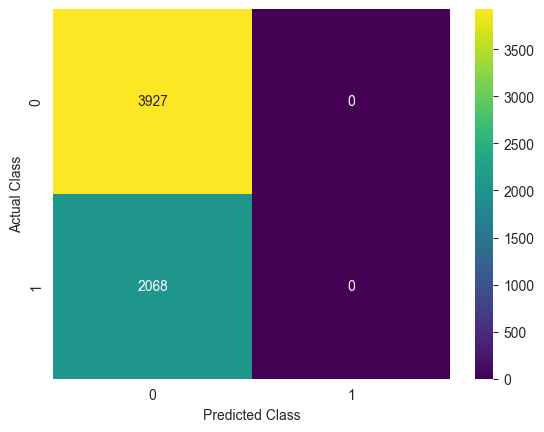

In [10]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

#### Logistic Regression (Best Model) :

--------------------Training Performance---------------------
0.713946117274168
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     15564
           1       0.74      0.28      0.41      8414

    accuracy                           0.71     23978
   macro avg       0.73      0.61      0.61     23978
weighted avg       0.72      0.71      0.67     23978

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7137614678899082
              precision    recall  f1-score   support

           0       0.71      0.94      0.81      3927
           1       0.71      0.29      0.41      2068

    accuracy                           0.71      5995
   macro avg       0.71      0.61      0.61      5995
weighted avg       0.71      0.71      0.67      5995



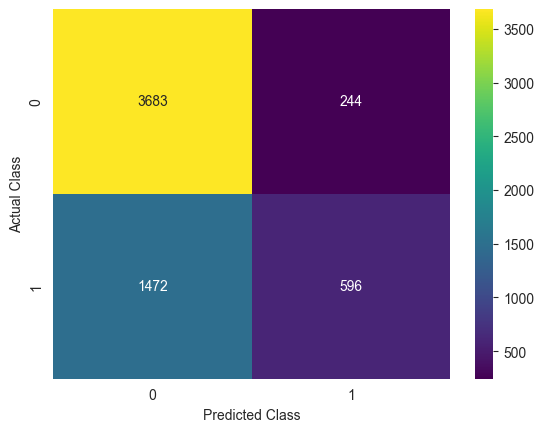

In [11]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

#### Random forest:

--------------------Training Performance---------------------
0.8753440653932771
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     15564
           1       0.98      0.66      0.79      8414

    accuracy                           0.88     23978
   macro avg       0.91      0.83      0.85     23978
weighted avg       0.89      0.88      0.87     23978

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7047539616346956
              precision    recall  f1-score   support

           0       0.71      0.92      0.80      3927
           1       0.66      0.29      0.41      2068

    accuracy                           0.70      5995
   macro avg       0.69      0.61      0.60      5995
weighted avg       0.70      0.70      0.67      5995



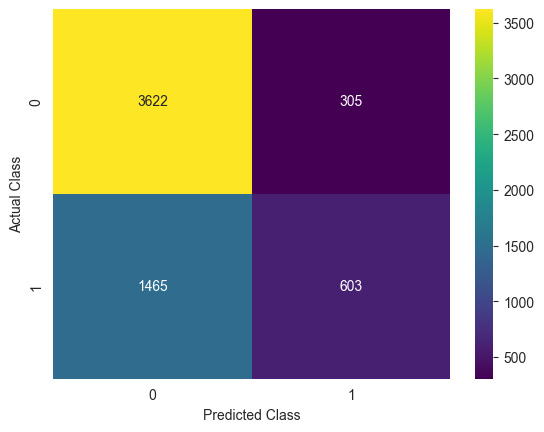

In [12]:
model = RandomForestClassifier(n_estimators=50,max_depth=15,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

In [13]:
print("finished")

finished
